# Demo for Property Inference Attack (PIA)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/privML/privacy-evaluator/blob/team2sprint6/notebooks/property_inference_attack.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png/" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/privML/privacy-evaluator/blob/team2sprint6/notebooks/property_inference_attack.ipynb"><img src="https://raw.githubusercontent.com/privML/privacy-evaluator/main/notebooks/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>




## Overview
In this notebook, we want to show you how to use the privacy-evaluator tool to perform the Property Inference Attack on a provided Pytorch model trained with the MNIST dataset. <br>
The goal of the Property Inference Attack is to find out whether the training dataset of a given model has a specific property (for more detailed information about the property inference attack take a look at [this paper](https://dl.acm.org/doi/pdf/10.1145/3243734.3243834) or at [Youtube](https://www.youtube.com/watch?v=99YHPIsKzCc&)).


![Property_Inference_Attack](https://i.imgur.com/IX1M3TX.png)


In our example the property we're trying to find out is the class distribution of the training dataset.

## Setup

First, you should set the notebook's runtime to use a GPU (e.g. if Colab is used go to ***Runtime > Change runtime type > Hardware accelerator***). Now we can install the `privacy-evaluator` package and import all needed modules.

In [1]:
!pip3 install git+https://github.com/privML/privacy-evaluator@team2sprint6

  Cloning https://github.com/privML/privacy-evaluator (to revision team2sprint6) to /tmp/pip-req-build-4mw9usng
  Running command git clone -q https://github.com/privML/privacy-evaluator /tmp/pip-req-build-4mw9usng
  Running command git checkout -b team2sprint6 --track origin/team2sprint6
  Switched to a new branch 'team2sprint6'
  Branch 'team2sprint6' set up to track remote branch 'team2sprint6' from 'origin'.
  Created wheel for privacy-evaluator: filename=privacy_evaluator-0.1-py3-none-any.whl size=28626590 sha256=8e18ec027a606a113173d29fc9b0b9f4e913c4c68efa433bdf279554fbd286da
  Stored in directory: /tmp/pip-ephem-wheel-cache-azb9jbf2/wheels/7f/0f/11/80d2a6bbd0578d9c0e306bdc4cc85602a9d9d0ee5976fa41ef
Successfully built privacy-evaluator


In [2]:
from privacy_evaluator.attacks.property_inference_attack import PropertyInferenceClassDistributionAttack
from privacy_evaluator.classifiers.classifier import Classifier
from privacy_evaluator.utils.data_utils import (
    dataset_downloader,
    new_dataset_from_size_dict,
)
from privacy_evaluator.utils.model_utils import create_and_train_torch_ConvNet_model

from matplotlib import pyplot as plt


# Conduct Property Inference Attack
Now we can start with conducting the Property Inference Attack.


## 1. Preparation of the dataset


### 1.1 Download the dataset


We will work with the MNIST dataset.<br>
MNIST is a dataset of black-and-white handwritten digits from 10 classes (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), consisting of 60000 training- and 10000 test-images.

First, we download the MNIST dataset.<br>
The size of each image is $28\times 28 \times 1$.

In [3]:
train_dataset, test_dataset = dataset_downloader("MNIST")
input_shape = test_dataset[0][0].shape
print(f"Input shape of images: {input_shape}")

Input shape of images: (28, 28, 1)


You can see some sample images of the MNIST dataset printed below.


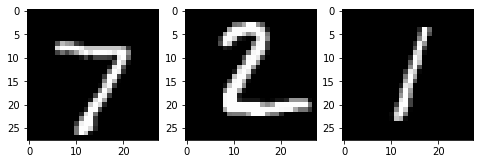

In [4]:
#Print images
images = test_dataset[0][:3]
_, axs = plt.subplots(1, 3, figsize=(8, 8))
axs = axs.flatten()
for image, ax in zip(images, axs):
    ax.imshow(image.squeeze(), cmap='gray')
plt.show()

### 1.2 Adjustment of dataset to binary attack


As of now, we can only perform binary attacks.<br>
A binary attack is an attack, where the target model is only classifying into 2 different classes.<br>
This means that the dataset the target model is trained on only contains two different classes. For our example we therefore use classes 0 and 1 from MNIST, which represent the digits 0 and 1.

We specify a distribution of these two classes (`NUM_ELEMENTS_PER_CLASSES`) and adjust the MNIST dataset accordingly. <br>
On this adjusted dataset we will train our target model and later the attacks' goal is to predict this distribution.

In [5]:
NUM_ELEMENTS_PER_CLASSES = {0: 500, 1: 1000}
train_set = new_dataset_from_size_dict(train_dataset, NUM_ELEMENTS_PER_CLASSES)
print(f"Amount of images per class: {NUM_ELEMENTS_PER_CLASSES}")
print(f"Amount of images in total: {train_set[1].shape}")
print(f"Size of each image: {train_set[0][0].shape}")

Amount of images per class: {0: 500, 1: 1000}
Amount of images in total: (1500,)
Size of each image: (28, 28, 1)


## 2. Load and train target model


We now load our target model.<br>
We use a convolutional neural network (CNN) and train it on the dataset created in the step before. 

We then convert it to an ART classifier to make it compatible with the [Adversial Robustness Toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox). <br>
ART is a python library for machine learning security, which's code we used for the other notebooks about the membership inference attack. <br>
Hence, to standardize this attack with the others, we convert the classifier to an ART classifier. <br>
To conlude, this step is not important to understand for the actual attack but might be interesting to know for you if you know ART.

Our target model is now all set for the actual attack on it.

In [6]:
num_classes = len(NUM_ELEMENTS_PER_CLASSES)
model = create_and_train_torch_ConvNet_model(train_set, num_channels=(input_shape[-1], 16, 32, 64), num_epochs=8)

# Convert to ART classifier
target_model = Classifier._to_art_classifier(model, "sparse_categorical_crossentropy", num_classes, input_shape)

100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


## 3. Perform attack


### 3.1 Overview over whole attack

One property inference attack consists of several property inference subattacks for different distributions of the training data. One subattack is running for one ratio (e.g. 66% class 0, 34% class 1) and predicts whether it's more likely that the distribution of the training data of the target model was according to this special ratio or a balanced distribution (50% class 0, 50% class 1). <br>
We specify the ratios in `ratios_for_attack`. We only specify one ratio for class 0 in the list, the other one for class 1 is automatically computed in the attack (1 - ratio for class 0). <br>
The whole attack then checks, which distribution of the subattacks has the highest probability.

![Property_Inference_Attack_overview](https://i.imgur.com/yHPc8bO.png)

### 3.2 Overview over a subattack


In every subattack we create a number of shadow classifiers of the same architecture as the provided target model.

![shadow_classifiers](https://i.imgur.com/vffpROO.jpg)

Half of the shadow classifiers is trained on an unbalanced data set of the given ratio (e.g. 70% class 0, 30% class 1) - our property -, the other half is trained on a balanced data sets (50% class 0, 50% class 1) - our negation of property.

![shadow_training_sets](https://i.imgur.com/ryUDdbK.jpg)

Once created and trained, the features of the shadow classifiers are extracted. Generally speaking, the extracted features are nothing more than on what specifics of the image the model determined its prediction. <br>
The extracted features are then the training data for the meta classifier. This means that the meta classifier is trained to distinguish between the property and the negation of property (unbalanced with specific ratio vs. balanced).

![meta_classifier](https://i.imgur.com/mhpkRm2.jpg)

Hence, the meta classifier gets as an input the feature extraction of the target model. 

If the data set used for the target model does indeed follow the property (unbalanced with specific ratio), the extracted features of the target model will show similarities to the feature extractions of the shadow classifiers trained on data sets that follow the property. Thus, the meta classifier will predict in this case that the likelihood of the target model to have the given property is higher than it having the negation of the property (similar procedure in the opposite case that the data set of the target model follows the negation of the property).

To conclude, the meta classifier is the model which finally predicts the likelihood of the target model to have a given property (i.e. the ratio).

![prediction](https://i.imgur.com/Skf8j7S.jpg)

### 3.3 Perform actual attack

To now perform the attack, we first define how many shadow classifiers we want to create (`number_of_shadow_classifiers`). In `size_shadow_training_set` we define the size of the training data set for each shadow classifier. 

As you can see, in our example attack we set `number_of_shadow_classifiers` to 2, and `size_shadow_training_set` to 6. This means that two shadow classifiers will be trained (remember: in a subattack half of the shadow classifiers follow the property, half follow the negation of property so in our case 1 shadow classifier is trained on an unbalanced data set, 1 shadow classifier is trained on a balanced data set). Each shadow classifier is trained on a data set with 6 images.

For both parameters we chose really small numbers due to runtime issues, but for a real attack <1000 shadow classifiers are not recommended and also the size set should be increased according to the size of the dataset you're sampling from. In the case of MNIST set sizes between 500 and 1500 are reasonable.

We also define which classes we want to use for our binary attack (`classes`) and the unbalanced ratios for each subattack (`ratios_for_attack`). 

In our case, two subattacks will be performed, one with 34% images from class 0 and 66% images from class 1, the other with 95% from class 0, 5% from class 1.

We again chose fewer ratios due to runtime issues. For a real attack, it is again recommended having many more subattacks for more ratios.

In [13]:
# Number of shadow classifiers (increase for better accuracy of the meta classifier, decrease when not enough computing power is available.)
number_of_shadow_classifiers = 2 #needs to be even

# Size of data set to train the shadow classifiers
size_shadow_training_set = 6

# Ratios to perform the attack for (the real ratio of our example target model is 0.66: {0: 500, 1: 1000}: 34% of data points are from class 0, 66% from class 1.)
# In this case, one subattack is performed with ratio 66% for class 1 (like the described target model ratio), the other one with ratio 0.05% for class 1
ratios_for_attack = [0.66, 0.05]

# Number of epochs for training the meta classifier
num_epochs_meta_classifier = 10

#Classes that the attack should be performed on
classes = [0, 1] #needs to be two values (binary attack)

We then perform the attack on the target model (`target_model`) with our MNIST dataset (`train_set`) and with the values that we defined just now. Further, the verbose variable is set to 1 which means that when you run the attack you will get some printed statements of what the attack is doing right now. <br>
The attack consists of all the steps explained in "3.1 Overview over whole attack" and "3.2 Overview over a subattack".

We save the output of the attack in the variable `output`.

In [14]:
attack = PropertyInferenceClassDistributionAttack(
    target_model, train_set, verbose=1, size_shadow_training_set=size_shadow_training_set, 
    ratios_for_attack=ratios_for_attack, classes=classes, amount_sets=number_of_shadow_classifiers, 
    num_epochs_meta_classifier=num_epochs_meta_classifier
)
output = attack.attack()

INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Initiating Property Inference Attack ... 
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Extracting features from target model ... 
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:(97634,) --- features extracted from the target model.
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Creating set of 1 balanced shadow classifier(s) ... 
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Creating shadow training sets
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Training 1 shadow classifier(s):
Training 1 shadow classifier(s): 100%|██████████| 1/1 [00:00<00:00, 35.01it/s]
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Performing PIA for the following ratios: [0.05, 0.66].
Performing 2 sub-attack(s):  

INFO:privacy_evaluator.utils.trainer:Training a shadow classifier in 20 epochs ...
INFO:privacy_evaluator.utils.trainer:Training a shadow classifier in 20 epochs ...






















Training 1 shadow classifier(s): 100%|██████████| 1/1 [00:10<00:00, 10.56s/it]
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Initialize meta-classifier ... 
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Training meta-classifier for 10 epochs ... 


Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 1.2662 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 583ms/step - loss: 0.6316 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 1s 556ms/step - loss: 0.4013 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 1s 560ms/step - loss: 0.9976 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 1s 559ms/step - loss: 2.1670 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 1s 586ms/step - loss: 0.3952 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 1s 559ms/step - loss: 0.2740 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 1s 579ms/step - loss: 0.4855 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 1s 561ms/step - loss: 0.7853 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 1s 602ms/step - loss: 0.2057 - accuracy: 1.0000


Performing 2 sub-attack(s):  50%|█████     | 1/2 [00:22<00:22, 22.29s/it]INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Sub-attack for ratio 0.66 ... 
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Creating shadow training sets
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Training 1 shadow classifier(s):

Performing 2 sub-attack(s):  50%|█████     | 1/2 [00:22<00:22, 22.29s/it]


INFO:privacy_evaluator.utils.trainer:Training a shadow classifier in 20 epochs ...


Training 1 shadow classifier(s): 100%|██████████| 1/1 [00:00<00:00, 19.41it/s]
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Initialize meta-classifier ... 
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:Training meta-classifier for 10 epochs ... 


Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 1.0133 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 712ms/step - loss: 1.7736 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 562ms/step - loss: 3.4974 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 1s 550ms/step - loss: 0.2438 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 1s 577ms/step - loss: 0.2376 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 562ms/step - loss: 0.8999 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 1s 561ms/step - loss: 2.0685 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 1s 558ms/step - loss: 1.0560 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 1s 568ms/step - loss: 0.3533 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 1s 591ms/step - loss: 0.6217 - accuracy: 1.000

Performing 2 sub-attack(s): 100%|██████████| 2/2 [00:36<00:00, 18.07s/it]
INFO:privacy_evaluator.attacks.property_inference_attack.property_inference_attack:PIA completed!


## 4. Output of attack

### 4.1 Whole output


The output consists of two elements. <br>
 One is a string with a message where the actual prediction is printed. <br>


In [15]:
output.max_message

'The most probable property is class 0: 0.34, class 1: 0.66 with a probability of 0.5229109525680542.'

The other one is a dictionary where for every ratio specified before in `ratios_for attack` we get the likelihood that the training set was this ratio.

In [16]:
output.output

{'class 0: 0.95, class 1: 0.05': 0.4948887,
 'class 0: 0.34, class 1: 0.66': 0.52291095}

### 4.2 Understanding the output

The human readable output message is the string, it gives us the actual prediction. 


In [17]:
output.max_message

'The most probable property is class 0: 0.34, class 1: 0.66 with a probability of 0.5229109525680542.'

E.g. the output is _'The most probable property is class 0: 0.34, class 1: 0.66 with a probability of 0.5118420720100403.'_ 
 
The part of the output _'class 0: 0.34, class 1: 0.66 with a probability of 0.5118420720100403.'_ means that the subattack which had as the unbalanced ratio (property) for the data set 
 - 34 % of the images in the data set are from class 0
 - 66% % of the images in the data set are from class 1 
 
had a ~51% chance of this being the distribution of the data set the target model was trained rather than a balanced distribution. <br>
In other words: The chance that the distribution of the target model's data set was balanced instead of 34% / 66% is ~49%.

Now looking at the whole string _'The most probable property is class 0: 0.34, class 1: 0.66 with a probability of 0.5118420720100403.'_: This means that the prediction is the most likely property. In other words, from all the unbalanced ratios (class distributions) that were tested as properties in the subattacks, this property has the highest probability. <br>
Hence, from all unbalanced class distributions tested, this is most likely the class distribution of the data set the target model was trained on.

It is important to mention that so far, the attack only outputs the most likely distribution from all unbalanced distributions that were tested. The negation of the property (balanced distribution) is neglected so far as more research is needed to answer this question.<br>
This means that the output right now does not say whether the data set the target model was trained on is balanced or unbalanced but rather which of the tested unbalanced ratios is the most likely.<br>
To avoid this shortcoming of the attack to have influence on our example, we therefore performed the attack on a target model that was trained on an unbalanced data set (66%, 34%).

![output](https://i.imgur.com/mZeGe6N.png)

The more detailed output you could use for visualization or further analysis is the dictionary. <br>
This output shows the probability for all ratios, not only the most likely.
It is similar constructed to above in detailed described probability for the most likely ratio.

In [18]:
output.output

{'class 0: 0.95, class 1: 0.05': 0.4948887,
 'class 0: 0.34, class 1: 0.66': 0.52291095}

### 4.3 Improve output

#### 4.3.1 Probabilities close to 0.5

If all the probabilities are close to 0.5 and none is standing out significantly from all the others you could try using more shadow classifiers (= make the training set for the meta classifier larger). You could plot your probabilities so you can see, whether they're all really close like in our demonstration.


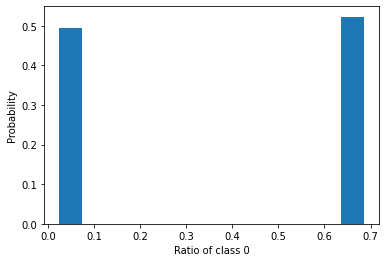

In [19]:
import numpy as np
x = output.output.values()
plt.bar(ratios_for_attack,x, width= 0.05)
plt.ylabel("Probability")
plt.xlabel("Ratio of class 0")
plt.show()

#### 4.3.2 Output overall

As mentioned before, we used very small values to make the notebook quick and easy to use. 

To perform a stronger attack generally speaking, we would advise to use more shadow classifiers (>1000), bigger shadow training sets (for MNIST > 500) and more subattacks (= more ratios). 